In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import zipfile
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
local_zip = '/content/drive/MyDrive/data_folder.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data_folder')
zip_ref.close()

base_dir = '/content/data_folder'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')

test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')

In [7]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [8]:
train_cats_generator = datagen.flow_from_directory(
    directory=train_dir,
    classes=['cat'],
    target_size=(64, 64),
    batch_size=64,
    class_mode=None,
    shuffle=False)

train_dogs_generator = datagen.flow_from_directory(
    directory=train_dir,
    classes=['dog'],
    target_size=(64, 64),
    batch_size=64,
    class_mode=None,
    shuffle=False)
test_cats_generator = datagen.flow_from_directory(
    directory=test_dir,
    classes=['cat'],
    target_size=(64, 64),
    batch_size=64,
    class_mode=None,
    shuffle=False)

test_dogs_generator = datagen.flow_from_directory(
    directory=test_dir,
    classes=['dog'],
    target_size=(64, 64),
    batch_size=64,
    class_mode=None,
    shuffle=False)

Found 9972 images belonging to 1 classes.
Found 10028 images belonging to 1 classes.
Found 1278 images belonging to 1 classes.
Found 1222 images belonging to 1 classes.


In [9]:
def get_subset(generator, num_images):
    features = []
    count = 0
    for images in generator:
        features.append(images)
        count += images.shape[0]
        if count >= num_images:
            break
    features = np.concatenate(features)[:num_images]
    return features

In [10]:
train_cats_features = get_subset(train_cats_generator, 1000)
test_cats_features = get_subset(test_cats_generator, 500)
train_dogs_features = get_subset(train_dogs_generator, 1000)
test_dogs_features = get_subset(test_dogs_generator, 500)

In [11]:
train_cats_labels = np.zeros(train_cats_features.shape[0])
test_cats_labels = np.zeros(test_cats_features.shape[0])
train_dogs_labels = np.ones(train_dogs_features.shape[0])
test_dogs_labels = np.ones(test_dogs_features.shape[0])

In [12]:
train_features = np.concatenate([train_cats_features, train_dogs_features])
train_labels = np.concatenate([train_cats_labels, train_dogs_labels])
test_features = np.concatenate([test_cats_features, test_dogs_features])
test_labels = np.concatenate([test_cats_labels, test_dogs_labels])

In [13]:
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

In [14]:
indices = np.random.permutation(train_features_flat.shape[0])
train_features_flat = train_features_flat[indices]
train_labels = train_labels[indices]

In [15]:
print(train_features_flat.shape, train_labels.shape)
print(test_features_flat.shape, test_labels.shape)

(2000, 12288) (2000,)
(1000, 12288) (1000,)


In [ ]:
svm_param_dist = {
    'C': randint(1, 100),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

rfc_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None] + list(randint(10, 100).rvs(2)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

knn_param_dist = {
    'n_neighbors': randint(1,100),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [ ]:
svm = SVC()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()

In [ ]:
# Perform Randomized Search CV for Random Forest
rfc_random_search = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_param_dist, n_iter=30, cv=3)
rfc_random_search.fit(train_features_flat, train_labels)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'max_depth': [None, 86, 11],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79d7bca80040>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79d7bc7ad570>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79d7bc7ac220>})

In [ ]:
rfc_best_params = rfc_random_search.best_params_
print("Best Random Forest Hyperparameters:", rfc_best_params)
print("Random Forest Accuracy:", rfc_random_search.best_score_)

Best Random Forest Hyperparameters: {'max_depth': 86, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 183}
Random Forest Accuracy: 0.6323333333333333


In [ ]:
print(rfc_random_search.score(test_features_flat, test_labels))

0.624


First test: 81, 6, 2, 165
Second test: 77, 4, 5, 182
Third test: 86, 6, 5, 183

In [ ]:
# Perform Randomized Search CV for KNN
knn_random_search = RandomizedSearchCV(estimator=knn, param_distributions=knn_param_dist, n_iter=30, cv=3)
knn_random_search.fit(train_features_flat, train_labels)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=30,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78c47e7c24d0>,
                                        'weights': ['uniform', 'distance']})

In [ ]:
knn_best_params = knn_random_search.best_params_
print("Best KNN Hyperparameters:", knn_best_params)
print("KNN Accuracy:", knn_random_search.best_score_)

Best KNN Hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 34, 'weights': 'distance'}
KNN Accuracy: 0.5710261159362956


First test: auto, 59, uniform
Second test: auto, 54, distance
Third test: ball_tree, 34, distance

In [ ]:
svm_random_search = RandomizedSearchCV(estimator=svm, param_distributions=svm_param_dist, n_iter=10, cv=3)
svm_random_search.fit(train_features_flat, train_labels)

In [ ]:
svm_best_params = svm_random_search.best_params_
print("Best SVM Hyperparameters:", svm_best_params)
print("SVM Accuracy:", svm_random_search.best_score_)

Best SVM Hyperparameters: {'C': 6, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy: 0.6266666666666666


In [ ]:
print(svm_random_search.score(test_features_flat, test_labels))

First test: 41, scale, rbf
Second test: 30, scale, rbf
Third test: 6, scale, rbf


In [ ]:
svm_param_grid = {
    'C': np.arange(30,41),
    'kernel': ['rbf'],
    'gamma': ['scale']
}

rfc_param_grid = {
    'n_estimators': np.arange(180,184),
    'max_depth': np.arange(80, 86),
    'min_samples_split': [5],
    'min_samples_leaf': [6]
}

knn_param_grid = {
    'n_neighbors': np.arange(55,61),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree']
}

In [ ]:
svm = SVC()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()

In [ ]:
svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=3)
svm_grid_search.fit(train_features_flat, train_labels)
print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best score for SVM:", svm_grid_search.best_score_)
print("Test score for SVM:", svm_grid_search.score(test_features_flat, test_labels))
#1378.221s

Best parameters for SVM: {'C': 30, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVM: 0.6019917968943457
Test score for SVM: 0.6135


In [ ]:
rfc_grid_search = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=3)
rfc_grid_search.fit(train_features_flat, train_labels)
print("Best parameters for Random Forest:", rfc_grid_search.best_params_)
print("Best score for Random Forest:", rfc_grid_search.best_score_)
print("Test score for Random Forest:", rfc_grid_search.score(test_features_flat, test_labels))
#890.379s

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for Random Forest: {'max_depth': 81, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 181}
Best score for Random Forest: 0.6294945620282952
Test score for Random Forest: 0.6135


In [ ]:
knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=3, n_jobs=-1)
knn_grid_search.fit(train_features_flat, train_labels)
print("Best parameters for KNN:", knn_grid_search.best_params_)
print("Best score for knn:", knn_grid_search.best_score_)
print("Test score for knn:", knn_grid_search.score(test_features_flat, test_labels))
#101.836s

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 57, 'weights': 'uniform'}
Best score for knn: 0.5734940337638988
Test score for knn: 0.5725


In [ ]:
with open('/content/drive/MyDrive/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_grid_search.best_estimator_, f)

with open('/content/drive/MyDrive/rfc_model.pkl', 'wb') as f:
    pickle.dump(rfc_grid_search.best_estimator_, f)

with open('/content/drive/MyDrive/knn_model.pkl', 'wb') as f:
    pickle.dump(knn_grid_search.best_estimator_, f)

In [16]:
with open('/content/drive/MyDrive/svm_model.pkl', 'rb') as f:
    loaded_svm_model = pickle.load(f)

with open('/content/drive/MyDrive/rfc_model.pkl', 'rb') as f:
    loaded_rfc_model = pickle.load(f)

with open('/content/drive/MyDrive/knn_model.pkl', 'rb') as f:
    loaded_knn_model = pickle.load(f)

In [17]:
models = {
    'SVM': loaded_svm_model,
    'RFC': loaded_rfc_model,
    'KNN': loaded_knn_model
}

SVM Classification Report:
              precision    recall  f1-score   support

         Cat       0.61      0.66      0.63       500
         Dog       0.63      0.57      0.60       500

    accuracy                           0.62      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.62      0.62      0.62      1000



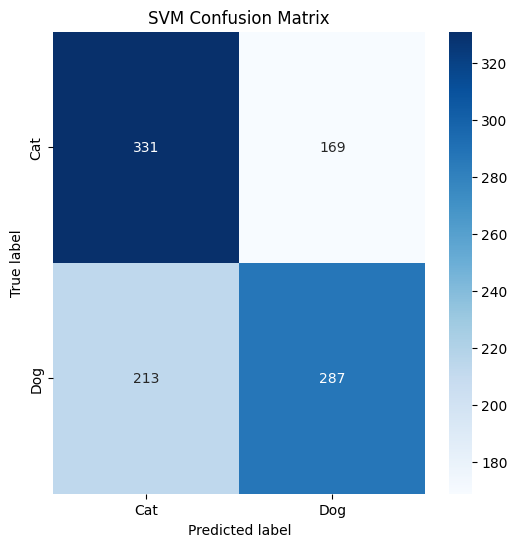

Random Forest Classification Report:
              precision    recall  f1-score   support

         Cat       0.60      0.58      0.59       500
         Dog       0.59      0.61      0.60       500

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000



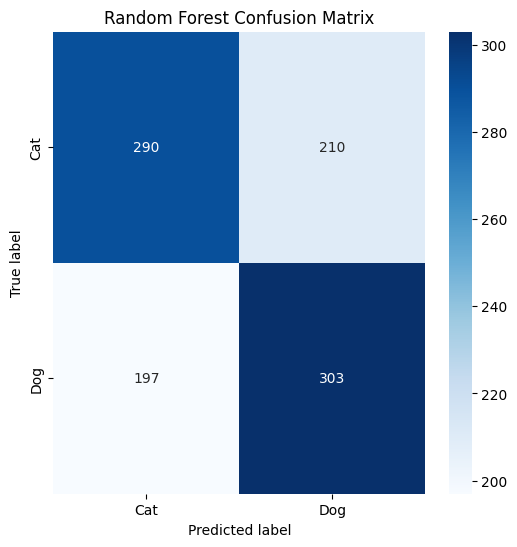

KNN Classification Report:
              precision    recall  f1-score   support

         Cat       0.58      0.47      0.52       500
         Dog       0.55      0.66      0.60       500

    accuracy                           0.56      1000
   macro avg       0.57      0.56      0.56      1000
weighted avg       0.57      0.56      0.56      1000



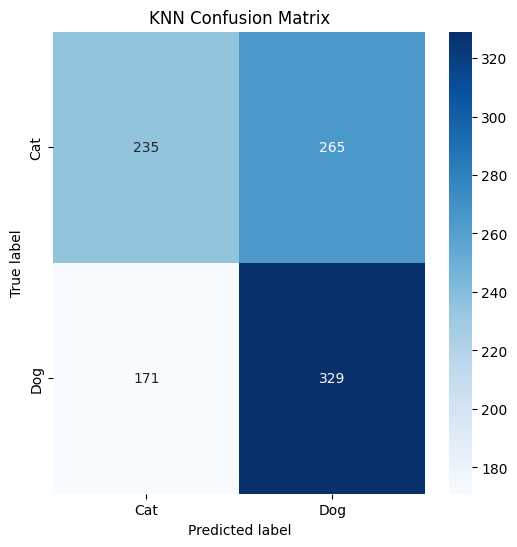

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = ['Cat', 'Dog']

svm_predictions = loaded_svm_model.predict(test_features_flat)
print("SVM Classification Report:")
print(classification_report(test_labels, svm_predictions, target_names=class_names))
svm_cm = confusion_matrix(test_labels, svm_predictions)
plot_confusion_matrix(svm_cm, class_names, title='SVM Confusion Matrix')

rfc_predictions = loaded_rfc_model.predict(test_features_flat)
print("Random Forest Classification Report:")
print(classification_report(test_labels, rfc_predictions, target_names=class_names))
rfc_cm = confusion_matrix(test_labels, rfc_predictions)
plot_confusion_matrix(rfc_cm, class_names, title='Random Forest Confusion Matrix')

knn_predictions = loaded_knn_model.predict(test_features_flat)
print("KNN Classification Report:")
print(classification_report(test_labels, knn_predictions, target_names=class_names))
knn_cm = confusion_matrix(test_labels, knn_predictions)
plot_confusion_matrix(knn_cm, class_names, title='KNN Confusion Matrix')
